In [1]:
import warnings
warnings.filterwarnings('ignore')
import stwcs
import glob
import sys
import os
import shutil
import time
import filecmp
import astroquery
import progressbar
import copy
import requests
import random
import astropy.wcs as wcs
import numpy as np
from contextlib import contextmanager
from astropy import units as u
from astropy.utils.data import clear_download_cache,download_file
from astropy.io import fits
from astropy.table import Table, Column, unique
from astropy.time import Time
from astroscrappy import detect_cosmics
from stwcs import updatewcs
from scipy.interpolate import interp1d

# Internal dependencies
from common import Constants
from common import Options
from common import Settings
from common import Util
from nbutils import get_filter, get_instrument, get_chip, get_filter, input_list
from nbutils import get_zpt, add_visit_info, organize_reduction_tables, pick_deepest_images

@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

with suppress_stdout():
    from drizzlepac import tweakreg,astrodrizzle,catalogs,photeq
    from astroquery.mast import Observations
    from astropy.coordinates import SkyCoord

In [2]:
acceptable_filters = [
    'F220W','F250W','F330W','F344N','F435W','F475W','F550M','F555W',
    'F606W','F625W','F660N','F660N','F775W','F814W','F850LP','F892N',
    'F098M','F105W','F110W','F125W','F126N','F127M','F128N','F130N','F132N',
    'F139M','F140W','F153M','F160W','F164N','F167N','F200LP','F218W','F225W',
    'F275W','F280N','F300X','F336W','F343N','F350LP','F373N','F390M','F390W',
    'F395N','F410M','F438W','F467M','F469N','F475X','F487N','F547M',
    'F600LP','F621M','F625W','F631N','F645N','F656N','F657N','F658N','F665N',
    'F673N','F680N','F689M','F763M','F845M','F953N','F122M','F160BW','F185W',
    'F218W','F255W','F300W','F375N','F380W','F390N','F437N','F439W','F450W',
    'F569W','F588N','F622W','F631N','F673N','F675W','F702W','F785LP','F791W',
    'F953N','F1042M']

In [3]:
catalog_pars = {
    'skysigma':0.0,
    'computesig':True,
    'conv_width':3.5,
    'sharplo':0.2,
    'sharphi':1.0,
    'roundlo':-1.0,
    'roundhi':1.0,
    'peakmin':None,
    'peakmax':None,
    'fluxmin':None,
    'fluxmax':None,
    'nsigma':1.5,
    'ratio':1.0,
    'theta':0.0,
    'use_sharp_round': True,
    'expand_refcat': False,
    'enforce_user_order': True,
    'clean': True,
    'interactive': False,
    'verbose': False,
    'updatewcs': False,
    'xyunits': 'pixels',
    '_RULES_': {'_rule_1':'True', '_rule2_':'False'}
}

### Get obstable

In [4]:
workdir = '.'
input_images = [s for p in ['*flc.fits', '*flt.fits'] for s in glob.glob(os.path.join(workdir, p))]

In [5]:
obstable = input_list(input_images)

In [6]:
obstable

image,exptime,datetime,filter,instrument,detector,zeropoint,chip,imagenumber,visit,drizname
str20,float64,str19,str5,str12,str7,float64,str2,int64,int64,str99
./icn105dvq_flt.fits,452.936035,2014-10-06T14:22:18,f140w,wfc3_ir_full,wfc3_ir,26.45070798348457,IR,0,1,./wfc3.f140w.ut141006_0001.drz.fits
./icn105dwq_flt.fits,452.936035,2014-10-06T14:31:00,f140w,wfc3_ir_full,wfc3_ir,26.45070798348457,IR,0,1,./wfc3.f140w.ut141006_0001.drz.fits
./icn105dyq_flt.fits,252.934357,2014-10-06T14:39:42,f105w,wfc3_ir_full,wfc3_ir,26.26452349235223,IR,0,2,./wfc3.f105w.ut141006_0002.drz.fits
./icn105e0q_flt.fits,252.934357,2014-10-06T14:44:57,f105w,wfc3_ir_full,wfc3_ir,26.26452349235223,IR,0,2,./wfc3.f105w.ut141006_0002.drz.fits
./icn105e2q_flt.fits,252.934357,2014-10-06T15:35:50,f105w,wfc3_ir_full,wfc3_ir,26.26452349235223,IR,0,2,./wfc3.f105w.ut141006_0002.drz.fits
./icn105e3q_flt.fits,252.934357,2014-10-06T15:41:05,f105w,wfc3_ir_full,wfc3_ir,26.26452349235223,IR,0,2,./wfc3.f105w.ut141006_0002.drz.fits


### Tweakreg

In [7]:
def tweakreg_error(exception):
    message = '\n\n' + '#'*80 + '\n'
    message += 'WARNING: tweakreg failed: {e}\n'
    message += '#'*80 + '\n'
    print(message.format(e=exception.__class__.__name__))
    print('Error:', exception)
    print('Adjusting thresholds and images...')

In [8]:
# Apply TWEAKSUC header variable if tweakreg was successful
def apply_tweakreg_success(shifts):

    for row in shifts:
        if ~np.isnan(row['xoffset']) and ~np.isnan(row['yoffset']):
            file=row['file']
            if not os.path.exists(file):
                file=row['file']
                print(f'WARNING: {file} does not exist!')
                continue
            hdu = fits.open(file, mode='update')
            hdu[0].header['TWEAKSUC']=1
            hdu.close()

In [9]:
def check_images_for_tweakreg(run_images):

    if not run_images:
        return(None)

    images = copy.copy(run_images)

    for file in list(images):
        print('Checking {0} for TWEAKSUC=1'.format(file))
        hdu = fits.open(file, mode='readonly')
        remove_image = ('TWEAKSUC' in hdu[0].header.keys() and
            hdu[0].header['TWEAKSUC']==1)

        if remove_image:
            images.remove(file)

    # If run_images is now empty, return None instead
    if len(images)==0:
        return(None)

    return(images)

In [10]:
def fix_hdu_wcs_keys(image, change_keys, ref_url):

    hdu = fits.open(image, mode='update')
    ref = ref_url.strip('.old')
    print('ref: ', ref)
    outdir = '.'
    if not outdir:
        outdir = '.'

    for i,h in enumerate(hdu):
        for key in hdu[i].header.keys():
            if 'WCSNAME' in key:
                print('WCSNAME', hdu[i].header[key])
                hdu[i].header[key] = hdu[i].header[key].strip()
        for key in change_keys:
            if key in list(hdu[i].header.keys()):
                val = hdu[i].header[key]
                print(key, val)
            else:
                continue
            if val == 'N/A':
                continue
            if (ref+'$' in val):
                ref_file = val.split('$')[1]
            else:
                ref_file = val

            fullfile = os.path.join(outdir, ref_file)
            if not os.path.exists(fullfile):
                print(f'Grabbing: {fullfile}')
                # Try using both old cdbs database and new crds link
                urls = []
                url = 'https://hst-crds.stsci.edu/unchecked_get/references/hst/'
                urls.append(url+ref_file)

                url = 'ftp://ftp.stsci.edu/cdbs/'
                urls.append(url+ref_url+'/'+ref_file)

                for url in urls:
                    message = f'Downloading file: {url}'
                    sys.stdout.write(message)
                    sys.stdout.flush()
                    try:
                        dat = download_file(url, cache=False,
                            show_progress=False, timeout=120)
                        shutil.move(dat, fullfile)
                        message = '\r' + message
                        message += Constants.green+' [SUCCESS]'+Constants.end+'\n'
                        sys.stdout.write(message)
                        break
                    except:
                        message = '\r' + message
                        message += Constants.red+' [FAILURE]'+Constants.end+'\n'
                        sys.stdout.write(message)
                        print(message)

            message = f'Setting {image},{i} {key}={fullfile}'
            print(message)
            hdu[i].header[key] = fullfile

        # WFPC2 does not have residual distortion corrections and astrodrizzle
        # choke if DGEOFILE is in header but not NPOLFILE.  So do a final check
        # for this part of the WCS keys
        if 'wfpc2' in get_instrument(image).lower():
            keys = list(h.header.keys())
            if 'DGEOFILE' in keys and 'NPOLFILE' not in keys:
                del hdu[i].header['DGEOFILE']

    hdu.writeto(image, overwrite=True, output_verify='silentfix')
    hdu.close()

In [11]:
def fix_idcscale(image):

    det = '_'.join(get_instrument(image).split('_')[:2])

    if 'wfc3' in det:
        hdu = fits.open(image)
        idcscale = 0.1282500028610229
        for i,h in enumerate(hdu):
            if 'IDCSCALE' not in hdu[i].header.keys():
                hdu[i].header['IDCSCALE']=idcscale

        hdu.writeto(image, overwrite=True, output_verify='silentfix')

In [12]:
# Update image wcs using updatewcs routine
def update_image_wcs(image, use_db=True):

    hdu = fits.open(image, mode='readonly')
    # Check if tweakreg was successfully run.  If so, then skip
    if 'TWEAKSUC' in hdu[0].header.keys() and hdu[0].header['TWEAKSUC']==1:
        return(True)

    # Check for hierarchical alignment.  If image has been shifted with
    # hierarchical alignment, we don't want to shift it again
    if 'HIERARCH' in hdu[0].header.keys() and hdu[0].header['HIERARCH']==1:
        return(True)

    hdu.close()

    message = 'Updating WCS for {file}'
    print(message.format(file=image))

#     self.clear_downloads(self.options['global_defaults'])

    change_keys = ['IDCTAB','DGEOFILE','NPOLEXT','NPOLFILE','D2IMFILE', 'D2IMEXT','OFFTAB']
    inst = get_instrument(image).split('_')[0]
    ref_url = 'iref.old'

    fix_hdu_wcs_keys(image, change_keys, ref_url)

    # Usually if updatewcs fails, that means it's already been done
    try:
        updatewcs.updatewcs(image, use_db=use_db) #probably not needed for jwst
        hdu = fits.open(image, mode='update')
        message = '\n\nupdatewcs success.  File info:'
        print(message)
        hdu.info()
        hdu.close()
        fix_hdu_wcs_keys(image, change_keys, ref_url)
        fix_idcscale(image)
        return(True)
    except:
        error = 'ERROR: failed to update WCS for image {file}'
        print(error.format(file=image))
        return(None)

In [14]:
def run_cosmic(image, options, output=None):
    message = 'Cleaning cosmic rays in image: {image}'
    print(message.format(image=image))
    hdulist = fits.open(image,mode='readonly')

    if output is None:
        output = image

    for i,hdu in enumerate(hdulist):
        if hdu.name=='SCI':
            mask = np.zeros(hdu.data.shape, dtype=np.bool_)

            crmask, crclean = detect_cosmics(hdu.data.copy().astype('<f4'),
                inmask=mask, readnoise=options['rdnoise'], gain=options['gain'],
                satlevel=options['saturate'], sigclip=options['sig_clip'],
                sigfrac=options['sig_frac'], objlim=options['obj_lim'])

            hdulist[i].data[:,:] = crclean[:,:]

            # Add crmask data to DQ array or DQ image
            if False:
                if 'flc' in image or 'flt' in image:
                    # Assume this hdu is corresponding DQ array
                    if len(hdulist)>=i+2 and hdulist[i+2].name=='DQ':
                        hdulist[i+2].data[np.where(crmask)]=4096
                elif 'c0m' in image:
                    maskfile = image.split('_')[0]+'_c1m.fits'
                    if os.path.exists(maskfile):
                        maskhdu = fits.open(maskfile)
                        maskhdu[i].data[np.where(crmask)]=4096
                        maskhdu.writeto(maskfile, overwrite=True)

    # This writes in place
    hdulist.writeto(output, overwrite=True, output_verify='silentfix')
    hdulist.close()

In [15]:
def get_nsources(image, thresh):
    imghdu = fits.open(image)
    nsources = 0
    message = '\n\nGetting number of sources in {im} at threshold={thresh}'
    print(message.format(im=image, thresh=thresh))
    for i,h in enumerate(imghdu):
        if h.name=='SCI' or (len(imghdu)==1 and h.name=='PRIMARY'):
            filename="{:s}[{:d}]".format(image, i)
            wcs = stwcs.wcsutil.HSTWCS(filename)
            catalog_mode = 'automatic'
            catalog = catalogs.generateCatalog(wcs, mode=catalog_mode,
                catalog=filename, threshold=thresh,
                **catalog_pars)
            try:
                catalog.buildCatalogs()
                nsources += catalog.num_objects
            except:
                pass

    message = 'Got {n} total sources'
    print(message.format(n=nsources))

    return(nsources)

def count_nsources(images):
    cat_str = '_sci*_xy_catalog.coo'
    # Tag cat files with the threshold so we can reference it later
    n = 0
    for image in images:
        for catalog in glob.glob(image.replace('.fits',cat_str)):
            with open(catalog, 'r+') as f:
                for line in f:
                    if 'threshold' not in line:
                        n += 1

    return(n)

# Given an input image, look for a matching catalog and estimate what the
# threshold should be for this image.  If no catalog exists, generate one
# on the fly and estimate threshold
def get_tweakreg_thresholds(image, target):

    message = 'Getting tweakreg threshold for {im}.  Target nobj={t}'
    print(message.format(im=image, t=target))

    inp_data = []
    # Cascade down in S/N threshold until we exceed the target number of objs
    for t in np.flip([3.0,4.0,5.0,6.0,8.0,10.0,15.0,20.0,25.0,30.0,40.0,80.0]):
        nobj = get_nsources(image, t)
        # If no data yet, just add and continue
        if len(inp_data)<3:
            inp_data.append((float(nobj), float(t)))
        # If we're going backward - i.e., more objects than last run, then
        # just break
        elif nobj < inp_data[-1][0]:
            break
        else:
            # Otherwise, add the data and if we've already hit the target then
            # break
            inp_data.append((float(nobj), float(t)))
            if nobj > target: break

    return(inp_data)

def add_thresh_data(thresh_data, image, inp_data):
    if not thresh_data:
        keys = []
        data = []
        for val in inp_data:
            keys.append('%2.1f'%float(val[1]))
            data.append([val[0]])

        keys.insert(0, 'file')
        data.insert(0, [image])

        thresh_data = Table(data, names=keys)
        return(thresh_data)

    keys = []
    data = []
    for val in inp_data:
        key = '%2.1f'%float(val[1])
        keys.append(key)
        data.append(float(val[0]))
        if key not in thresh_data.keys():
            thresh_data.add_column(Column([np.nan]*len(thresh_data),
                name=key))

    keys.insert(0, 'file')
    data.insert(0, image)

    # Recast as table to prevent complaint aobut thresh_data.keys()
    thresh_data = Table(thresh_data)

    for key in thresh_data.keys():
        if key not in keys:
            data.append(np.nan)

    thresh_data.add_row(data)
    return(thresh_data)

def get_best_tweakreg_threshold(thresh_data, target):

    thresh = []
    nsources = []
    thresh_data = Table(thresh_data)
    for key in thresh_data.keys():
        if key=='file': continue
        thresh.append(float(key))
        nsources.append(float(thresh_data[key]))

    thresh = np.array(thresh)
    nsources = np.array(nsources)

    mask = (~np.isnan(thresh)) & (~np.isnan(nsources))
    thresh = thresh[mask]
    nsources = nsources[mask]

    # Interpolate the data and check what S/N target we want to get obj number
    thresh_func = interp1d(nsources, thresh, kind='linear', bounds_error=False,
        fill_value='extrapolate')
    threshold = thresh_func(target)

    # Set minimum and maximum threshold
    if threshold<3.0: threshold=3.0
    if threshold>1000.0: threshold=1000.0

    message = 'Using threshold: {t}'
    print(message.format(t=threshold))

    return(threshold)

In [21]:
test_image = tmp_images[0]

In [66]:
inp_data = get_tweakreg_thresholds('dummy.fits', 4000*4)
thresh_data = None
thresh_data = add_thresh_data(thresh_data, 'dummy.fits', inp_data)

Getting tweakreg threshold for dummy.fits.  Target nobj=16000


Getting number of sources in dummy.fits at threshold=80.0
  #  Source finding for 'dummy.fits', EXT=('SCI', 1) started at: 00:17:15.103 (03/07/2024)
     Found 16 objects.
  #  Source finding for 'dummy.fits', EXT=('SCI', 2) started at: 00:17:15.551 (03/07/2024)
     Found 41 objects.
Got 57 total sources


Getting number of sources in dummy.fits at threshold=40.0
  #  Source finding for 'dummy.fits', EXT=('SCI', 1) started at: 00:17:15.978 (03/07/2024)
     Found 30 objects.
  #  Source finding for 'dummy.fits', EXT=('SCI', 2) started at: 00:17:16.411 (03/07/2024)
     Found 57 objects.
Got 87 total sources


Getting number of sources in dummy.fits at threshold=30.0
  #  Source finding for 'dummy.fits', EXT=('SCI', 1) started at: 00:17:16.844 (03/07/2024)
     Found 42 objects.
  #  Source finding for 'dummy.fits', EXT=('SCI', 2) started at: 00:17:17.269 (03/07/2024)
     Found 67 objects.
Got 109 total sources


Getting 

In [67]:
thresh_data

file,80.0,40.0,30.0,25.0,20.0,15.0,10.0,8.0,6.0,5.0,4.0
str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
dummy.fits,57.0,87.0,109.0,123.0,157.0,202.0,314.0,441.0,2734.0,11930.0,46804.0


In [16]:
outdir = '.'
reference = ''
run_images = list(obstable['image'])
shift_table = Table([run_images, [np.nan]*len(run_images), 
                     [np.nan]*len(run_images)], names = ('file', 'xoffset', 'yoffset'))
tmp_images = []

In [17]:
# updates wcs, probably not needed for jwst/nircam
for image in run_images:
    if True and not False:
        det = '_'.join(get_instrument(image).split('_')[:2])
        update_image_wcs(image)

Updating WCS for ./icn105dvq_flt.fits
ref:  iref
IDCTAB ./w3m18525i_idc.fits
Grabbing: ././w3m18525i_idc.fits
Setting ./icn105dvq_flt.fits,0 IDCTAB=././w3m18525i_idc.fits
DGEOFILE N/A
NPOLFILE N/A
D2IMFILE N/A
WCSNAME OPUS
WCSNAME IDC_w3m18525i
WCSNAME IDC_w3m18525i-FIT_SVM_GAIADR2
IDCTAB N/A
NPOLFILE N/A
D2IMFILE N/A
WCSNAME IDC_w3m18525i
WCSNAME IDC_w3m18525i
WCSNAME IDC_w3m18525i
WCSNAME IDC_w3m18525i
WCSNAME OPUS
NPOLFILE N/A
D2IMFILE N/A
WCSNAME IDC_w3m18525i
NPOLFILE N/A
D2IMFILE N/A
WCSNAME IDC_w3m18525i-GSC240
NPOLFILE N/A
D2IMFILE N/A
WCSNAME IDC_w3m18525i-HSC30
NPOLFILE N/A
D2IMFILE N/A
WCSNAME IDC_w3m18525i-FIT_REL_GAIADR2
NPOLFILE N/A
D2IMFILE N/A
WCSNAME IDC_w3m18525i-FIT_REL_GAIADR1
NPOLFILE N/A
D2IMFILE N/A
WCSNAME IDC_w3m18525i-FIT_SVM_GAIADR2
NPOLFILE N/A
D2IMFILE N/A
WCSNAME IDC_w3m18525i
NPOLFILE N/A
D2IMFILE N/A
WCSNAME IDC_w3m18525i-FIT_REL_GAIAeDR3
NPOLFILE N/A
D2IMFILE N/A
AstrometryDB service available...
Deleted all instances of WCS with key A in extensions [1]

AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "icn105dvq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icn105dvq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icn105dvq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icn105dvq"
Retrieving astrometrically-updated WCS "OPUS-HSC30" for observation "icn105dvq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-HSC30" for observation "icn105dvq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-FIT_REL_GAIADR2" for observation "icn105dvq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-FIT_REL_GAIADR1" for observation "icn105dvq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-FIT_SVM_GAIADR2" for observation "icn105dvq"
Updating icn105dvq with:
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-FIT_SVM_GAIADR2


updatewcs success.  File info:
Filename: ./icn105dvq_flt.fits


AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "icn105dwq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icn105dwq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icn105dwq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icn105dwq"
Retrieving astrometrically-updated WCS "OPUS-HSC30" for observation "icn105dwq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-HSC30" for observation "icn105dwq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-FIT_REL_GAIADR2" for observation "icn105dwq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-FIT_REL_GAIADR1" for observation "icn105dwq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-FIT_SVM_GAIADR2" for observation "icn105dwq"
Updating icn105dwq with:
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-FIT_SVM_GAIADR2


updatewcs success.  File info:
Filename: ./icn105dwq_flt.fits


AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "icn105dyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icn105dyq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icn105dyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icn105dyq"
Retrieving astrometrically-updated WCS "OPUS-HSC30" for observation "icn105dyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-HSC30" for observation "icn105dyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-FIT_REL_GAIADR2" for observation "icn105dyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-FIT_REL_GAIADR1" for observation "icn105dyq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-FIT_SVM_GAIADR2" for observation "icn105dyq"
Updating icn105dyq with:
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-FIT_SVM_GAIADR2


updatewcs success.  File info:
Filename: ./icn105dyq_flt.fits


AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "icn105e0q"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icn105e0q"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icn105e0q"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icn105e0q"
Retrieving astrometrically-updated WCS "OPUS-HSC30" for observation "icn105e0q"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-HSC30" for observation "icn105e0q"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-FIT_REL_GAIADR2" for observation "icn105e0q"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-FIT_REL_GAIADR1" for observation "icn105e0q"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-FIT_SVM_GAIADR2" for observation "icn105e0q"
Updating icn105e0q with:
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-FIT_SVM_GAIADR2


updatewcs success.  File info:
Filename: ./icn105e0q_flt.fits


AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "icn105e2q"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icn105e2q"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icn105e2q"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icn105e2q"
Retrieving astrometrically-updated WCS "OPUS-HSC30" for observation "icn105e2q"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-HSC30" for observation "icn105e2q"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-FIT_REL_GAIADR2" for observation "icn105e2q"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-FIT_REL_GAIADR1" for observation "icn105e2q"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-FIT_SVM_GAIADR2" for observation "icn105e2q"
Updating icn105e2q with:
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-FIT_SVM_GAIADR2


updatewcs success.  File info:
Filename: ./icn105e2q_flt.fits


AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "icn105e3q"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "icn105e3q"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "icn105e3q"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "icn105e3q"
Retrieving astrometrically-updated WCS "OPUS-HSC30" for observation "icn105e3q"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-HSC30" for observation "icn105e3q"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-FIT_REL_GAIADR2" for observation "icn105e3q"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-FIT_REL_GAIADR1" for observation "icn105e3q"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-FIT_SVM_GAIADR2" for observation "icn105e3q"
Updating icn105e3q with:
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-FIT_SVM_GAIADR2


updatewcs success.  File info:
Filename: ./icn105e3q_flt.fits


In [18]:
# runs cosmic ray correction, probably not needed for jwst/nircam
for image in run_images:
        rawtmp = image.replace('.fits','.rawtmp.fits')
        tmp_images.append(rawtmp)
        
        # Check if rawtmp already exists
        if os.path.exists(rawtmp):
            message = '{file} exists. Skipping...'
            print(message.format(file=rawtmp))
            continue
        
        # Copy the raw data into a temporary file
        shutil.copyfile(image, rawtmp)

        # Clean cosmic rays so they aren't used for alignment
        inst = get_instrument(image).split('_')[0]
        crpars = {'rdnoise': 6.5,
                  'gain': 1.0,
                  'saturate': 70000.0,
                  'sig_clip': 3.0,
                  'sig_frac': 0.1,
                  'obj_lim': 5.0}
        run_cosmic(rawtmp, crpars)

Cleaning cosmic rays in image: ./icn105dvq_flt.rawtmp.fits
Cleaning cosmic rays in image: ./icn105dwq_flt.rawtmp.fits
Cleaning cosmic rays in image: ./icn105dyq_flt.rawtmp.fits
Cleaning cosmic rays in image: ./icn105e0q_flt.rawtmp.fits
Cleaning cosmic rays in image: ./icn105e2q_flt.rawtmp.fits
Cleaning cosmic rays in image: ./icn105e3q_flt.rawtmp.fits


In [19]:
twim = check_images_for_tweakreg(tmp_images)

Checking ./icn105dvq_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105dwq_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105dyq_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105e0q_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105e2q_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105e3q_flt.rawtmp.fits for TWEAKSUC=1


In [20]:
list(set(twim) ^ set(tmp_images))

[]

In [21]:
modified = False
ref_images = pick_deepest_images(tmp_images)
deepest = sorted(ref_images, key=lambda im: fits.getval(im, 'EXPTIME'))[-1]
if (not reference or reference=='dummy.fits'):
    reference = 'dummy.fits'
    message = 'Copying {deep} to reference dummy.fits'
    print(message.format(deep=deepest))
    shutil.copyfile(deepest, reference)
elif not self.prepare_reference_tweakreg(reference):
    # Can't use this reference image, just use one of the input
    reference = 'dummy.fits'
    message = 'Copying {deep} to reference dummy.fits'
    print(message.format(deep=deepest))
    shutil.copyfile(deepest, reference)
else:
    modified = True

message = 'Tweakreg is executing...'
print(message)

Copying ./icn105e3q_flt.rawtmp.fits to reference dummy.fits
Tweakreg is executing...


In [ ]:
tweakreg.TweakReg(files=['./jbqz24u1q_flc.rawtmp.fits'], refimage='dummy.fits',
    verbose=False, interactive=False, clean=True,
    writecat=True, updatehdr=True, reusename=True,
    rfluxunits='counts', minobj=10, wcsname='TWEAK',
    searchrad=1, searchunits='arcseconds', runfile='',
    tolerance=0.25, refnbright=4000, nbright=4000,
    separation=0.5, residplot='No plot', see2dplot=False,
    fitgeometry='shift',
    imagefindcfg = {'threshold': 4.8481,
        'conv_width': 3.5, 'use_sharp_round': True},
    refimagefindcfg = {'threshold': 4.8833,
        'conv_width': 3.5, 'use_sharp_round': True},
    shiftfile=True, outshifts='./drizzle_shifts.txt')

No trailer file created...
TweakReg Version 3.5.1 started at: 18:14:42.621 (10/07/2024) 

Version Information
--------------------
Python Version 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]
numpy Version -> 1.24.3 
astropy Version -> 6.1.0 
stwcs Version -> 1.7.2 
photutils Version -> 1.12.0 

Finding shifts for: 
    /home/aswin/hst123/jbqz24u1q_flc.rawtmp.fits

===  Source finding for image '/home/aswin/hst123/jbqz24u1q_flc.rawtmp.fits':
  #  Source finding for '/home/aswin/hst123/jbqz24u1q_flc.rawtmp.fits', EXT=('SCI', 1) started at: 18:14:42.767 (10/07/2024)
     Found 6470 objects.
  #  Source finding for '/home/aswin/hst123/jbqz24u1q_flc.rawtmp.fits', EXT=('SCI', 2) started at: 18:14:44.271 (10/07/2024)
     Found 7256 objects.
===  FINAL number of objects in image '/home/aswin/hst123/jbqz24u1q_flc.rawtmp.fits': 13726

===  Source finding for image 'dummy.fits':
  #  Source finding for 'dummy.fits', EXT=('SCI', 1) started at: 18:14:46.39 (10/07/2024)
     Found 6576 object

In [24]:
start_tweak = time.time()

tweakreg_success = False
tweak_img = copy.copy(tmp_images)
ithresh = 10 ; rthresh = 10
shallow_img = []
thresh_data = None
tries = 0
nbr = 4000

while (not tweakreg_success and tries < 10):
    tweak_img = check_images_for_tweakreg(tweak_img)
    if not tweak_img: break
    if tweak_img:
        # Remove images from tweak_img if they are too shallow
        if shallow_img:
            for img in shallow_img:
                if img in tweak_img:
                    tweak_img.remove(img)

        if len(tweak_img)==0:
            error = 'ERROR: removed all images as shallow'
            print(error)
            tweak_img = copy.copy(tmp_images)
            tweak_img = check_images_for_tweakreg(tweak_img)

        # If we've tried multiple runs and there are images in input
        # list with TWEAKSUC and reference image=dummy.fits, we might need
        # to try a different reference image
        success = list(set(tmp_images) ^ set(tweak_img))
        if tries > 1 and reference=='dummy.fits' and len(success)>0:
            # Make random success image new dummy image
            n = len(success)-1
            shutil.copyfile(success[random.randint(0,n)],'dummy.fits')

        # This estimates what the input threshold should be and cuts
        # out images based on number of detected sources from previous
        # rounds of tweakreg
        message = '\n\nReference image: {ref} \n'
        message += 'Images: {im}'
        print(message.format(ref=reference, im=','.join(tweak_img)))

        # Get deepest image and use threshold from that
        deepest = sorted(tweak_img,
            key=lambda im: fits.getval(im, 'EXPTIME'))[-1]

        if not thresh_data or deepest not in thresh_data['file']:
            inp_data = get_tweakreg_thresholds(deepest, nbr*4)
            thresh_data = add_thresh_data(thresh_data, deepest, inp_data)
        mask = thresh_data['file']==deepest
        inp_thresh = thresh_data[mask][0]
        print('Getting image threshold...')
        new_ithresh = get_best_tweakreg_threshold(inp_thresh, nbr*4)

        if not thresh_data or reference not in thresh_data['file']:
            inp_data = get_tweakreg_thresholds(reference, nbr*4)
            thresh_data = add_thresh_data(thresh_data, reference, inp_data)
        mask = thresh_data['file']==reference
        inp_thresh = thresh_data[mask][0]
        print('Getting reference threshold...')
        new_rthresh = get_best_tweakreg_threshold(inp_thresh, nbr*4)

        if not rthresh: rthresh = 10
        if not ithresh: ithresh = 10

        # Other input options
        nbright = nbr
        minobj = 10
        search_rad = int(np.round(1.0))
#         if search_radius: search_rad = search_radius

        rconv = 3.5 ; iconv = 3.5 ; tol = 0.25
        if 'wfc3_ir' in get_instrument(reference):
            rconv = 2.5
        if all(['wfc3_ir' in get_instrument(i)
            for i in tweak_img]):
            iconv = 2.5 ; tol = 0.6
        if 'wfpc2' in get_instrument(reference):
            rconv = 2.5
        if all(['wfpc2' in get_instrument(i)
            for i in tweak_img]):
            iconv = 2.5 ; tol = 0.5


        # Don't want to keep trying same thing over and over
        if (new_ithresh>=ithresh or new_rthresh>=rthresh) and tries>1:
            # Decrease the threshold and increase tolerance
            message = 'Decreasing threshold and increasing tolerance...'
            print(message)
            ithresh = np.max([new_ithresh*(0.95**tries), 3.0])
            rthresh = np.max([new_rthresh*(0.95**tries), 3.0])
            tol = tol * 1.3**tries
            search_rad = search_rad * 1.2**tries
        else:
            ithresh = new_ithresh
            rthresh = new_rthresh

        if tries > 7:
            minobj = 7

        message = '\nAdjusting thresholds:\n'
        message += 'Reference threshold={rthresh}\n'
        message += 'Image threshold={ithresh}\n'
        message += 'Tolerance={tol}\n'
        message += 'Search radius={rad}\n'
        print(message.format(ithresh='%2.4f'%ithresh,
            rthresh='%2.4f'%rthresh, tol='%2.4f'%tol,
            rad='%2.4f'%search_rad))

        outshifts = os.path.join(outdir, 'drizzle_shifts.txt')

        try:
            tweakreg.TweakReg(files=tweak_img, refimage=reference,
                verbose=False, interactive=False, clean=True,
                writecat=True, updatehdr=True, reusename=True,
                rfluxunits='counts', minobj=minobj, wcsname='TWEAK',
                searchrad=search_rad, searchunits='arcseconds', runfile='',
                tolerance=tol, refnbright=nbright, nbright=nbright,
                separation=0.5, residplot='No plot', see2dplot=False,
                fitgeometry='shift',
                imagefindcfg = {'threshold': ithresh,
                    'conv_width': iconv, 'use_sharp_round': True},
                refimagefindcfg = {'threshold': rthresh,
                    'conv_width': rconv, 'use_sharp_round': True},
                shiftfile=True, outshifts=outshifts)

            # Reset shallow_img list
            shallow_img = []

        except AssertionError as e:
            tweakreg_error(e)

            message = 'Re-running tweakreg with shallow images removed:'
            print(message)
            for img in tweak_img:
                nsources = get_nsources(img, ithresh)
                if nsources < 1000:
                    shallow_img.append(img)

        # Occurs when all images fail alignment
        except TypeError as e:
            tweakreg_error(e)

        # Record what the shifts are for each of the files run
        message='Reading in shift file: {file}'
        print(message.format(file=outshifts))
        shifts = Table.read(outshifts, format='ascii', names=('file',
            'xoffset','yoffset','rotation1','rotation2','scale1','scale2'))

        apply_tweakreg_success(shifts)

        # Add data from output shiftfile to shift_table
        for row in shifts:
            filename = os.path.basename(row['file'])
            filename = filename.replace('.rawtmp.fits','')
            filename = filename.replace('.fits','')

            idx = [i for i,row in enumerate(shift_table)
                if filename in row['file']]

            if len(idx)==1:
                shift_table[idx[0]]['xoffset']=row['xoffset']
                shift_table[idx[0]]['yoffset']=row['yoffset']

        if not check_images_for_tweakreg(tmp_images):
            tweakreg_success = True

        tries += 1

message = 'Tweakreg took {time} seconds to execute.\n\n'
print(message.format(time = time.time()-start_tweak))

print(shift_table)

Checking ./icn105dvq_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105dwq_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105dyq_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105e0q_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105e2q_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105e3q_flt.rawtmp.fits for TWEAKSUC=1


Reference image: dummy.fits 
Images: ./icn105dvq_flt.rawtmp.fits,./icn105dwq_flt.rawtmp.fits,./icn105dyq_flt.rawtmp.fits,./icn105e0q_flt.rawtmp.fits,./icn105e2q_flt.rawtmp.fits,./icn105e3q_flt.rawtmp.fits
Getting tweakreg threshold for ./icn105dwq_flt.rawtmp.fits.  Target nobj=16000


Getting number of sources in ./icn105dwq_flt.rawtmp.fits at threshold=80.0
  #  Source finding for './icn105dwq_flt.rawtmp.fits', EXT=('SCI', 1) started at: 00:42:32.112 (11/07/2024)
     Found 2 objects.
Got 2 total sources


Getting number of sources in ./icn105dwq_flt.rawtmp.fits at threshold=40.0
  #  Source finding for './icn105dwq_flt.rawtmp.fits', EXT=('SCI', 1) started at: 00:42:32.186 (11

     Found 45 objects.
===  FINAL number of objects in image '/home/aswin/hst123/icn105dyq_flt.rawtmp.fits': 45

===  Source finding for image '/home/aswin/hst123/icn105e0q_flt.rawtmp.fits':
  #  Source finding for '/home/aswin/hst123/icn105e0q_flt.rawtmp.fits', EXT=('SCI', 1) started at: 00:42:34.842 (11/07/2024)
     Found 40 objects.
===  FINAL number of objects in image '/home/aswin/hst123/icn105e0q_flt.rawtmp.fits': 40

===  Source finding for image '/home/aswin/hst123/icn105e2q_flt.rawtmp.fits':
  #  Source finding for '/home/aswin/hst123/icn105e2q_flt.rawtmp.fits', EXT=('SCI', 1) started at: 00:42:34.966 (11/07/2024)
     Found 26 objects.
===  FINAL number of objects in image '/home/aswin/hst123/icn105e2q_flt.rawtmp.fits': 26

===  Source finding for image '/home/aswin/hst123/icn105e3q_flt.rawtmp.fits':
  #  Source finding for '/home/aswin/hst123/icn105e3q_flt.rawtmp.fits', EXT=('SCI', 1) started at: 00:42:35.090 (11/07/2024)
     Found 28 objects.
===  FINAL number of objects 


Unable to match the following images:
-------------------------------------
/home/aswin/hst123/icn105e2q_flt.rawtmp.fits


Processing /home/aswin/hst123/icn105e2q_flt.rawtmp.fits['SCI',1]

Updating header for /home/aswin/hst123/icn105e2q_flt.rawtmp.fits[('SCI', 1)]
WCS Keywords

CD_11  CD_12: 3.4509924264219e-05 -1.3279163102345e-05
CD_21  CD_22: -1.4980079919527e-05 -3.0871092710907e-05
CRVAL    : 31.44204576592 -58.484454642104
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543550555834097
ORIENTAT : -156.72510096021898
WCSNAME  :  TWEAK
Writing out shiftfile : ./drizzle_shifts.txt
No trailer file saved...
Reading in shift file: ./drizzle_shifts.txt
Checking ./icn105dvq_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105dwq_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105dyq_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105e0q_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105e2q_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105e3q_flt.rawtmp.fits for TWEAKSUC=1
Checking ./i

===  Source finding for image '/home/aswin/hst123/icn105e2q_flt.rawtmp.fits':
  #  Source finding for '/home/aswin/hst123/icn105e2q_flt.rawtmp.fits', EXT=('SCI', 1) started at: 00:42:37.821 (11/07/2024)
     Found 26 objects.
===  FINAL number of objects in image '/home/aswin/hst123/icn105e2q_flt.rawtmp.fits': 26

===  Source finding for image 'dummy.fits':
  #  Source finding for 'dummy.fits', EXT=('SCI', 1) started at: 00:42:37.95 (11/07/2024)
     Found 45 objects.
===  FINAL number of objects in image 'dummy.fits': 45


Performing alignment in the projection plane defined by the WCS
derived from 'dummy.fits'


Performing fit for: /home/aswin/hst123/icn105e2q_flt.rawtmp.fits

Matching sources from '/home/aswin/hst123/icn105e2q_flt.rawtmp.fits' with sources from reference image 'dummy.fits'
Computing initial guess for X and Y shifts...
Found initial X and Y shifts of 0.7719, 0.7719 based on a single non-zero bin and 7 matches
##########################################################

Writing out shiftfile : ./drizzle_shifts.txt
No trailer file saved...
Reading in shift file: ./drizzle_shifts.txt
Checking ./icn105dvq_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105dwq_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105dyq_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105e0q_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105e2q_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105e3q_flt.rawtmp.fits for TWEAKSUC=1
Checking ./icn105e2q_flt.rawtmp.fits for TWEAKSUC=1


Reference image: dummy.fits 
Images: ./icn105e2q_flt.rawtmp.fits
Getting image threshold...
Using threshold: 3.0
Getting reference threshold...
Using threshold: 3.0
Decreasing threshold and increasing tolerance...

Adjusting thresholds:
Reference threshold=3.0000
Image threshold=3.0000
Tolerance=2.2278
Search radius=2.4883

No trailer file created...
TweakReg Version 3.5.1 started at: 00:42:39.242 (11/07/2024) 

Version Information
--------------------
Python Version 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.

In [22]:
import jhat
from jhat import hst_photclass,st_wcs_align

In [97]:
hst_phot = hst_photclass(psf_fwhm=1.8,aperture_radius= 5)
hst_phot.run_phot(imagename='jhat_run1/icn105e3q_flt.fits',photfilename='auto',overwrite=True)
ref_catname = 'jhat_run1/icn105e3q_flt.fits'.replace('.fits','.phot.txt') # the default
refcat = Table.read(ref_catname,format='ascii')
print(refcat)

0 jhat_run1/icn105e3q_flt.phot.txt
dmag 0.36200000000000004
aper_sum_5.0px annulus_median_5.0px aper_bkg_5.0px ...     ra       dec    
-------------- -------------------- -------------- ... --------- ----------
     68.540559             0.747304      58.693137 ... 31.460707  -58.47047
     67.763663             0.733793      57.631962 ... 31.473586  -58.47339
     66.540616             0.747744      58.727641 ... 31.431764 -58.463912
     68.711661             0.746278       58.61251 ... 31.436538 -58.464989
     67.240117             0.747011      58.670093 ... 31.442105 -58.466249
      82.14475             0.756164      59.388971 ... 31.471028 -58.472835
      67.59586             0.774641      60.840193 ...  31.42963 -58.463503
     68.442105             0.769584      60.442967 ... 31.439131 -58.465648
     67.758473             0.759806      59.675043 ... 31.444355 -58.466772
     71.995305             0.762208      59.863682 ...  31.47302 -58.473322
           ...              

0 ./jhat_run1//icn105dwq.phot.txt
dmag 0.36200000000000004
dmag 1.0
sharpness 0.9
roundness1 0.7
mag 25
x 974
y 974
reffile_d2d 0.5
*** Note: close plot to continue!


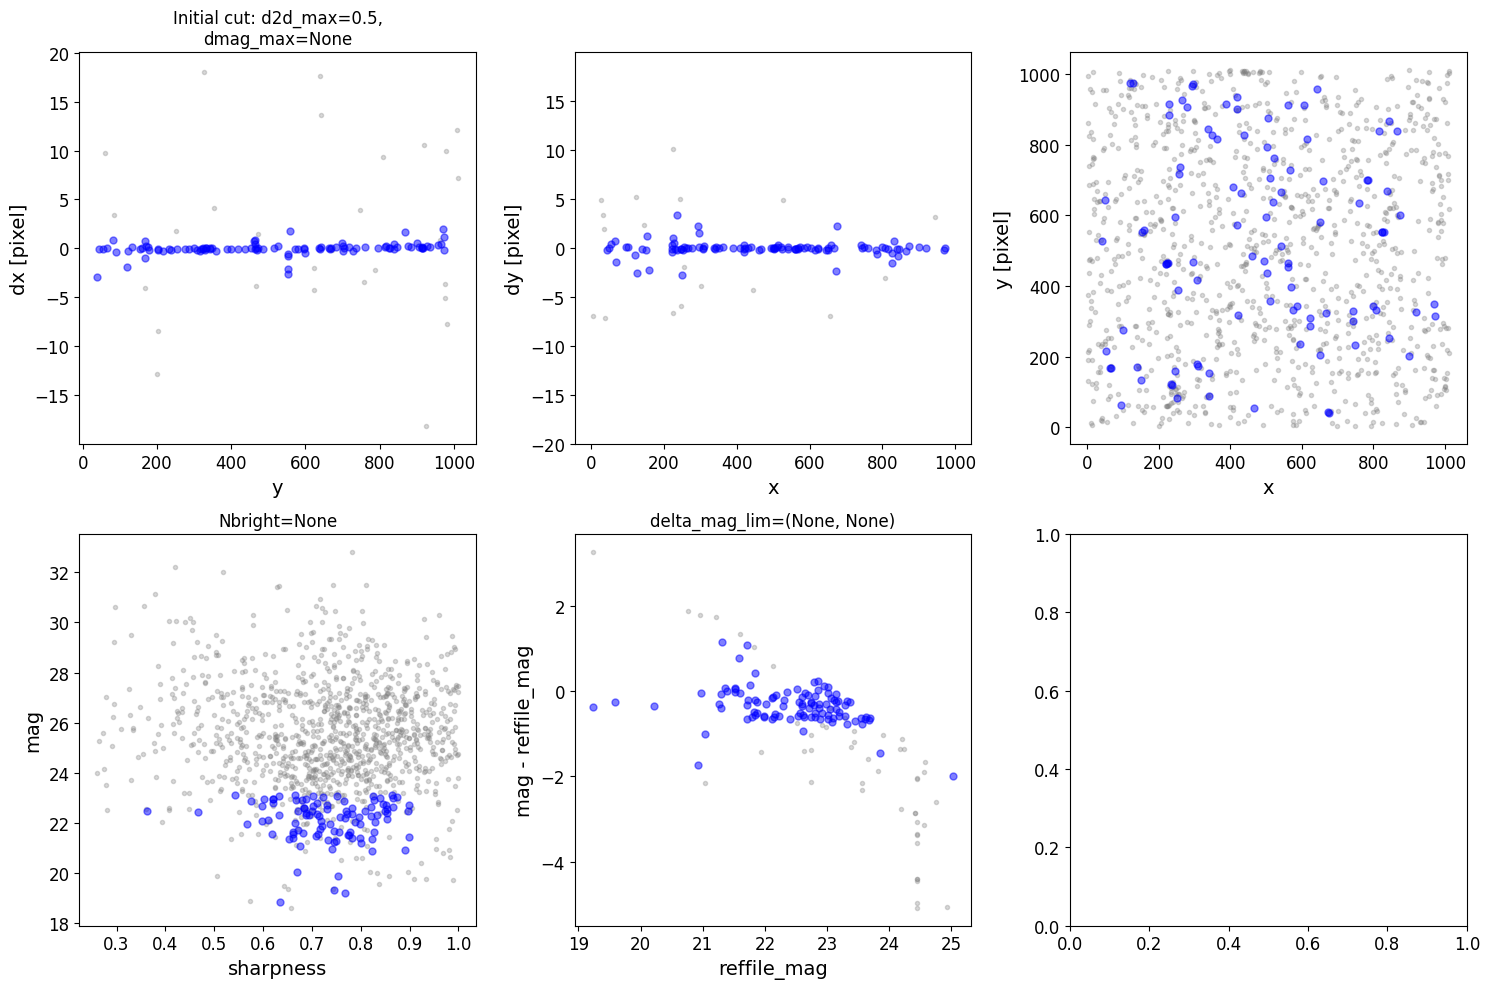

   slope  intercept    maxval  index  d_bestguess  fwhm  multimax
0.000293  -0.148535 70.147437    169     0.026377  0.58     False
d_rot_tmp 0.8263765571511346
Keeping 88 out of 88, skippin 0 because of null values in columns d_rot_tmp
median: 0.026984
75.000000 percentile cut: max residual for cut: 0.142449
__tmp_residuals 0.14244857457180676
median: 0.026984
i:00 mean:0.026984(0.008803) stdev:0.070974(0.006177) X2norm:0.99 Nchanged:0 Ngood:66 Nclip:22

mean: 0.016980
i:01 mean:0.016980(0.010202) stdev:0.086563(0.007164) X2norm:1.00 Nchanged:7 Ngood:73 Nclip:15

mean: 0.013869
i:02 mean:0.013869(0.010538) stdev:0.090037(0.007401) X2norm:1.00 Nchanged:1 Ngood:74 Nclip:14

mean: 0.013875
i:03 mean:0.013875(0.011445) stdev:0.099120(0.008040) X2norm:1.00 Nchanged:2 Ngood:76 Nclip:12

mean: 0.013875
i:04 mean:0.013875(0.011445) stdev:0.099120(0.008040) X2norm:1.00 Nchanged:0 Ngood:76 Nclip:12


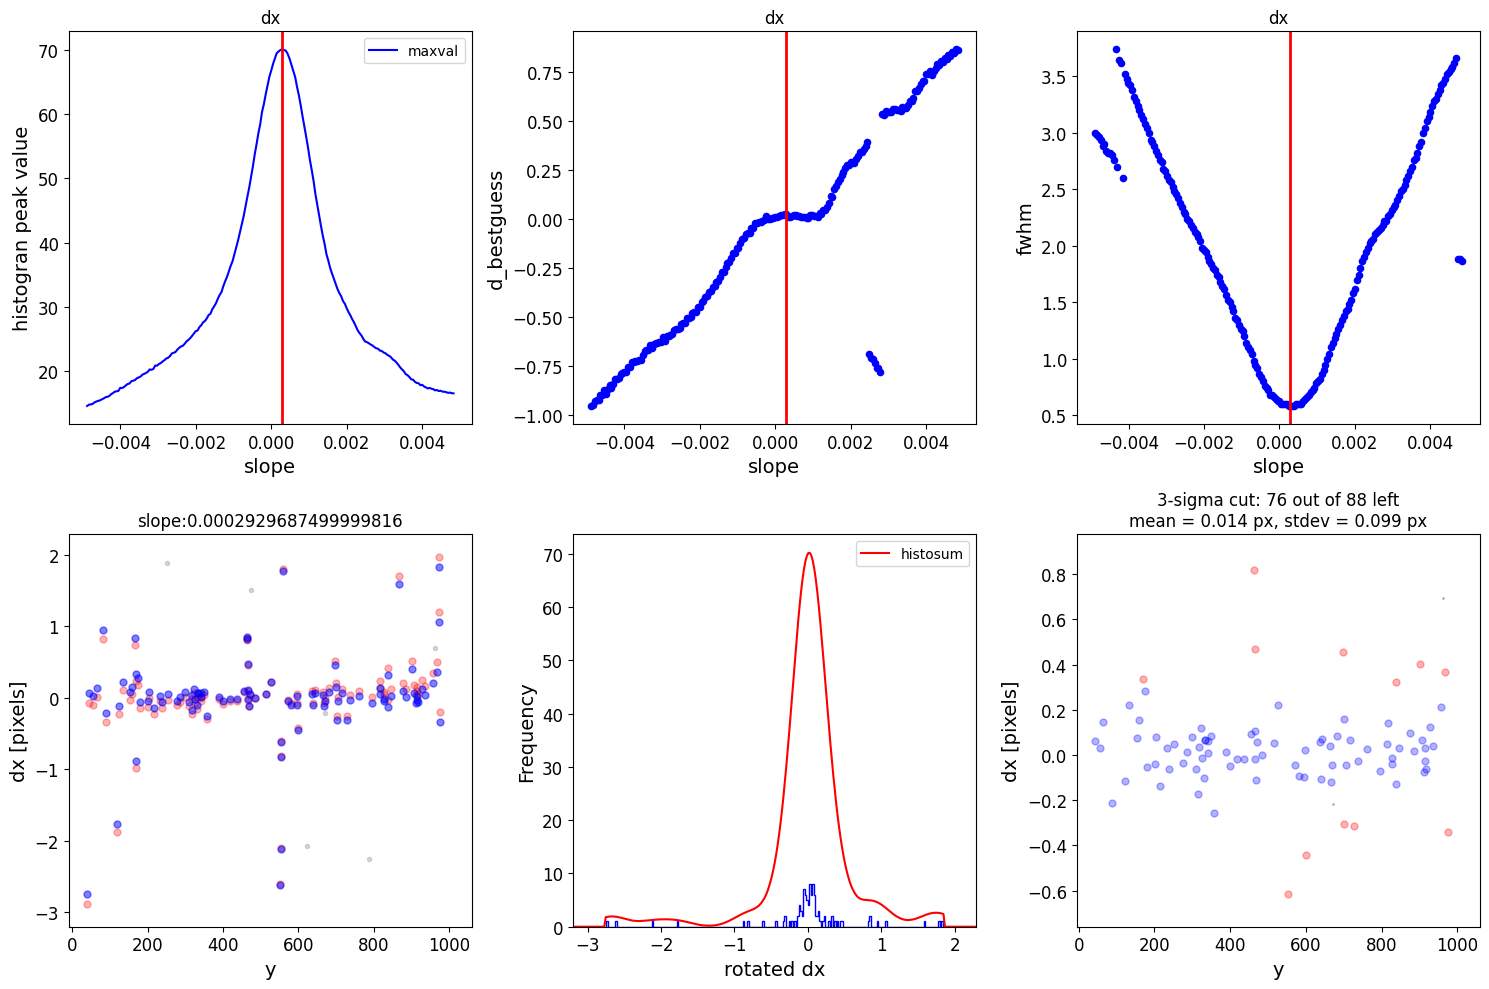

    slope  intercept    maxval  index  d_bestguess  fwhm  multimax
-0.000098   0.049512 62.765022    147    -0.055757  0.58     False
d_rot_tmp 0.744243418899224
Keeping 75 out of 75, skippin 0 because of null values in columns d_rot_tmp
median: -0.058395
75.000000 percentile cut: max residual for cut: 0.133159
__tmp_residuals 0.13315897462741771
median: -0.057702
i:00 mean:-0.057702(0.009339) stdev:0.069256(0.006544) X2norm:0.99 Nchanged:0 Ngood:56 Nclip:19

mean: -0.063239
i:01 mean:-0.063239(0.011348) stdev:0.090786(0.007962) X2norm:1.00 Nchanged:9 Ngood:65 Nclip:10

mean: -0.065652
i:02 mean:-0.065652(0.012706) stdev:0.105543(0.008920) X2norm:1.00 Nchanged:5 Ngood:70 Nclip:5

mean: -0.065652
i:03 mean:-0.065652(0.012706) stdev:0.105543(0.008920) X2norm:1.00 Nchanged:0 Ngood:70 Nclip:5


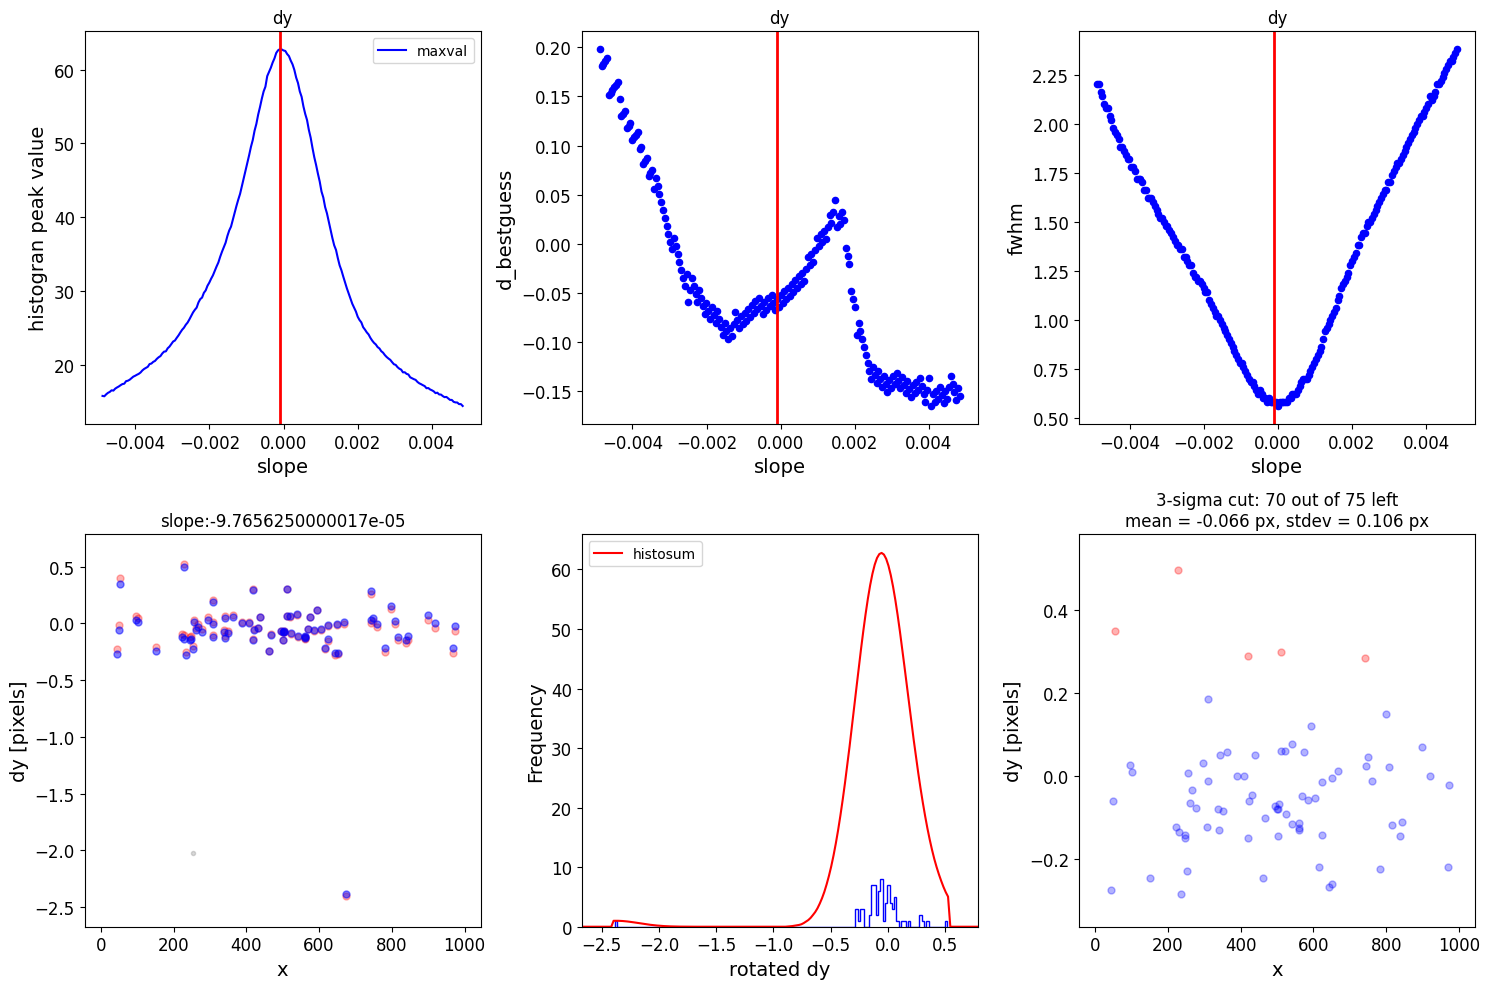

*** Note: close plots to continue!


<Figure size 640x480 with 0 Axes>

dx median of best matched objects of 1st iteration: 0.01585138392204044 dy median of best matched objects of 1st iteration: -0.06315358077378619
x 974
y 974
reffile_d2d 0.5
   slope  intercept    maxval  index  d_bestguess  fwhm  multimax
0.000293  -0.148535 70.753968    169     0.026377  0.58     False
d_rot_tmp 0.8263765571511346
Keeping 89 out of 89, skippin 0 because of null values in columns d_rot_tmp
median: 0.029023
75.000000 percentile cut: max residual for cut: 0.148873
__tmp_residuals 0.148872750168453
median: 0.026984
i:00 mean:0.026984(0.008803) stdev:0.070974(0.006177) X2norm:0.99 Nchanged:0 Ngood:66 Nclip:23

mean: 0.019681
i:01 mean:0.019681(0.010423) stdev:0.089053(0.007320) X2norm:1.00 Nchanged:8 Ngood:74 Nclip:15

mean: 0.020087
i:02 mean:0.020087(0.011177) stdev:0.096796(0.007851) X2norm:1.00 Nchanged:2 Ngood:76 Nclip:13

mean: 0.016511
i:03 mean:0.016511(0.011602) stdev:0.101146(0.008151) X2norm:1.00 Nchanged:1 Ngood:77 Nclip:12

mean: 0.016511
i:04 mean:0.016511(0.

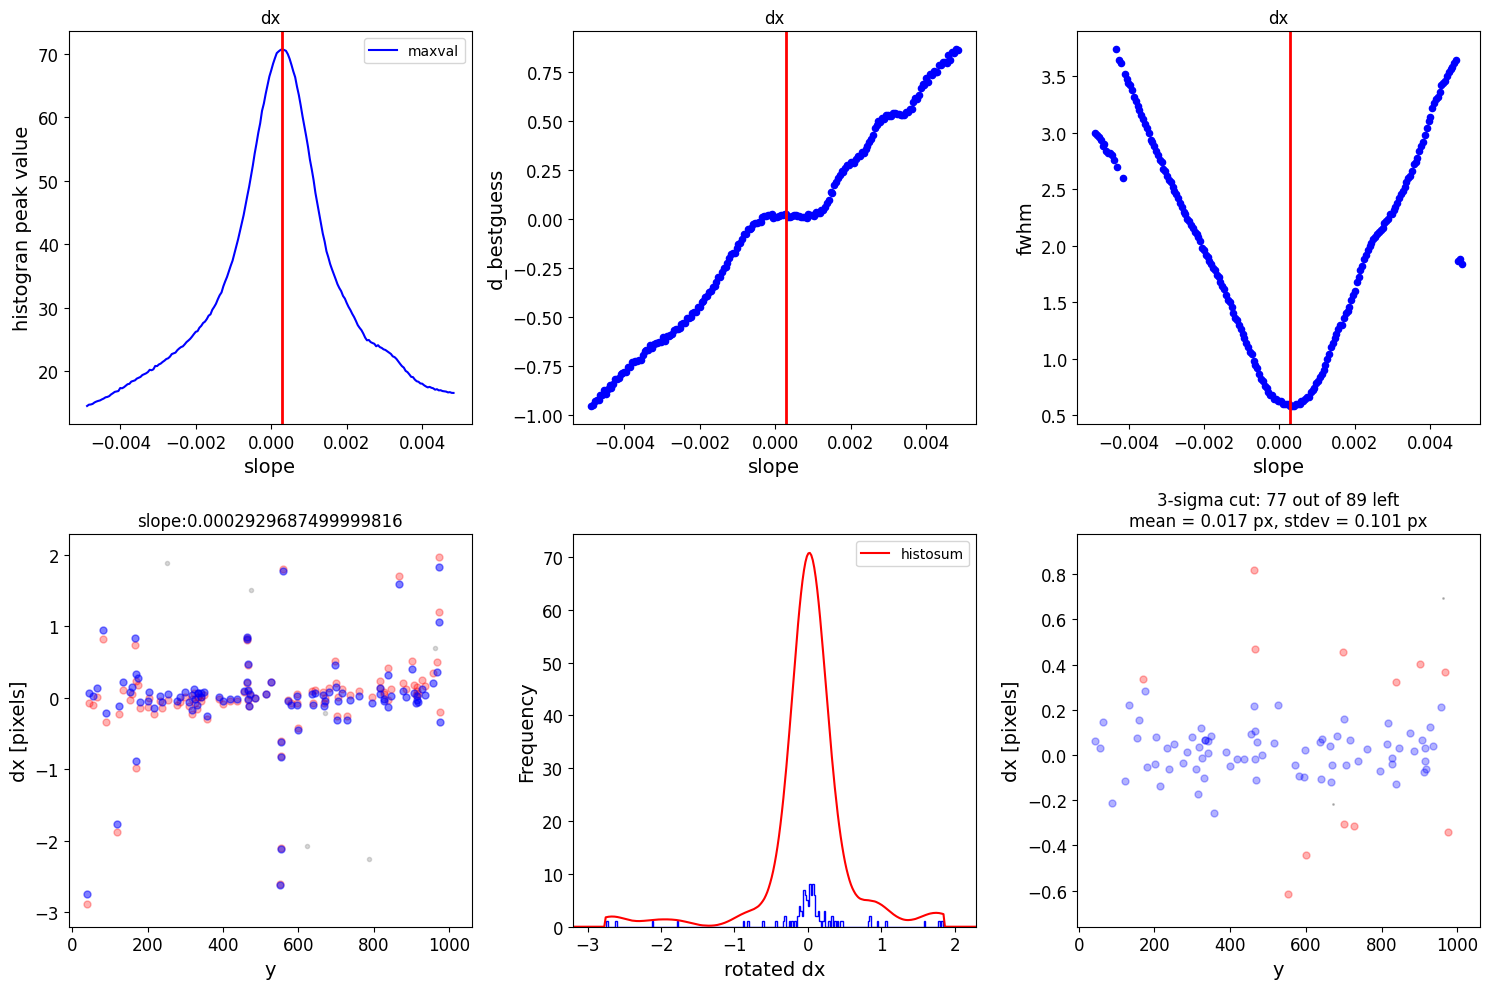

    slope  intercept    maxval  index  d_bestguess  fwhm  multimax
-0.000098   0.049512 63.760035    147    -0.055757  0.56     False
d_rot_tmp 0.744243418899224
Keeping 76 out of 76, skippin 0 because of null values in columns d_rot_tmp
median: -0.059186
75.000000 percentile cut: max residual for cut: 0.132079
__tmp_residuals 0.13207932605432104
median: -0.058395
i:00 mean:-0.058395(0.009188) stdev:0.068760(0.006440) X2norm:0.99 Nchanged:0 Ngood:57 Nclip:19

mean: -0.063380
i:01 mean:-0.063380(0.011175) stdev:0.090092(0.007842) X2norm:1.00 Nchanged:9 Ngood:66 Nclip:10

mean: -0.065749
i:02 mean:-0.065749(0.012525) stdev:0.104789(0.008794) X2norm:1.00 Nchanged:5 Ngood:71 Nclip:5

mean: -0.065749
i:03 mean:-0.065749(0.012525) stdev:0.104789(0.008794) X2norm:1.00 Nchanged:0 Ngood:71 Nclip:5


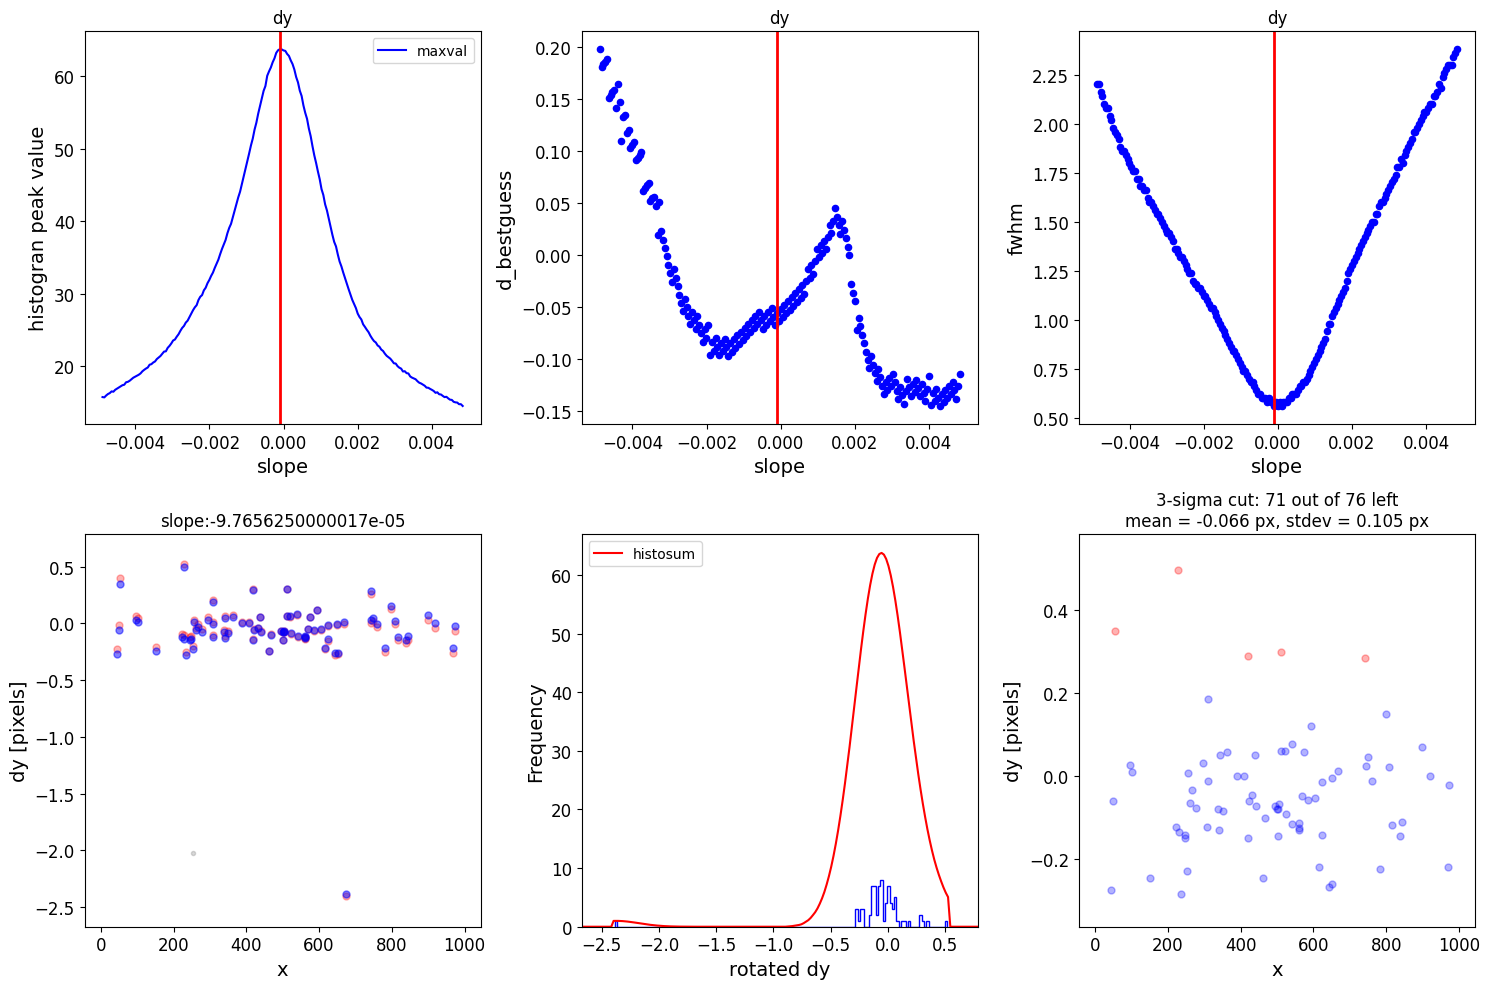

*** Note: close plots to continue!


<Figure size 640x480 with 0 Axes>

2024-07-12 00:26:10,229 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.
2024-07-12 00:26:10,662 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<ImageModel(1014, 1014) from icn105dwq_flt.fits>],).
2024-07-12 00:26:10,667 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /home/aswin/hst123/jhat_run1/icn105dwq_jhat.fits
  output_dir: ./jhat_run1
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_catalogs: False
  catalog_format: ecsv
  kernel_fwhm: 2.5
  snr_threshold: 50
  brightest: 4000
  peakmax: None
  enforce_user_order: False
  expand_refcat: False
  minobj: 4
  searchrad: 0.5
  use2dhist: True
  separation: 9
  tolerance: 0.7
  xoffset: 0
  yoffset: 0
  fitgeometry: rshift
  nclip: 3
  sigma: 3.0
  align_to_gaia: False
  gaia_catalog: GAIADR2
  min_gaia: 30
  save_ga

WCSAXES 2 2
CRPIX1 507.0 507.0
CRPIX2 507.0 507.0
CUNIT1 deg deg
CUNIT2 deg deg
CRVAL1 31.442036491223 31.442039831629
CRVAL2 -58.484460516987 -58.484458817142
CRDER1 35.095723028136 35.095723028136
CRDER2 26.519236064919 26.519236064919
WCSNAME IDC_w3m18525i-FIT_SVM_GAIADR2 IDC_w3m18525i-FIT_SVM_GAIADR2
MJDREF 0.0 0.0
RADESYS ICRS ICRS


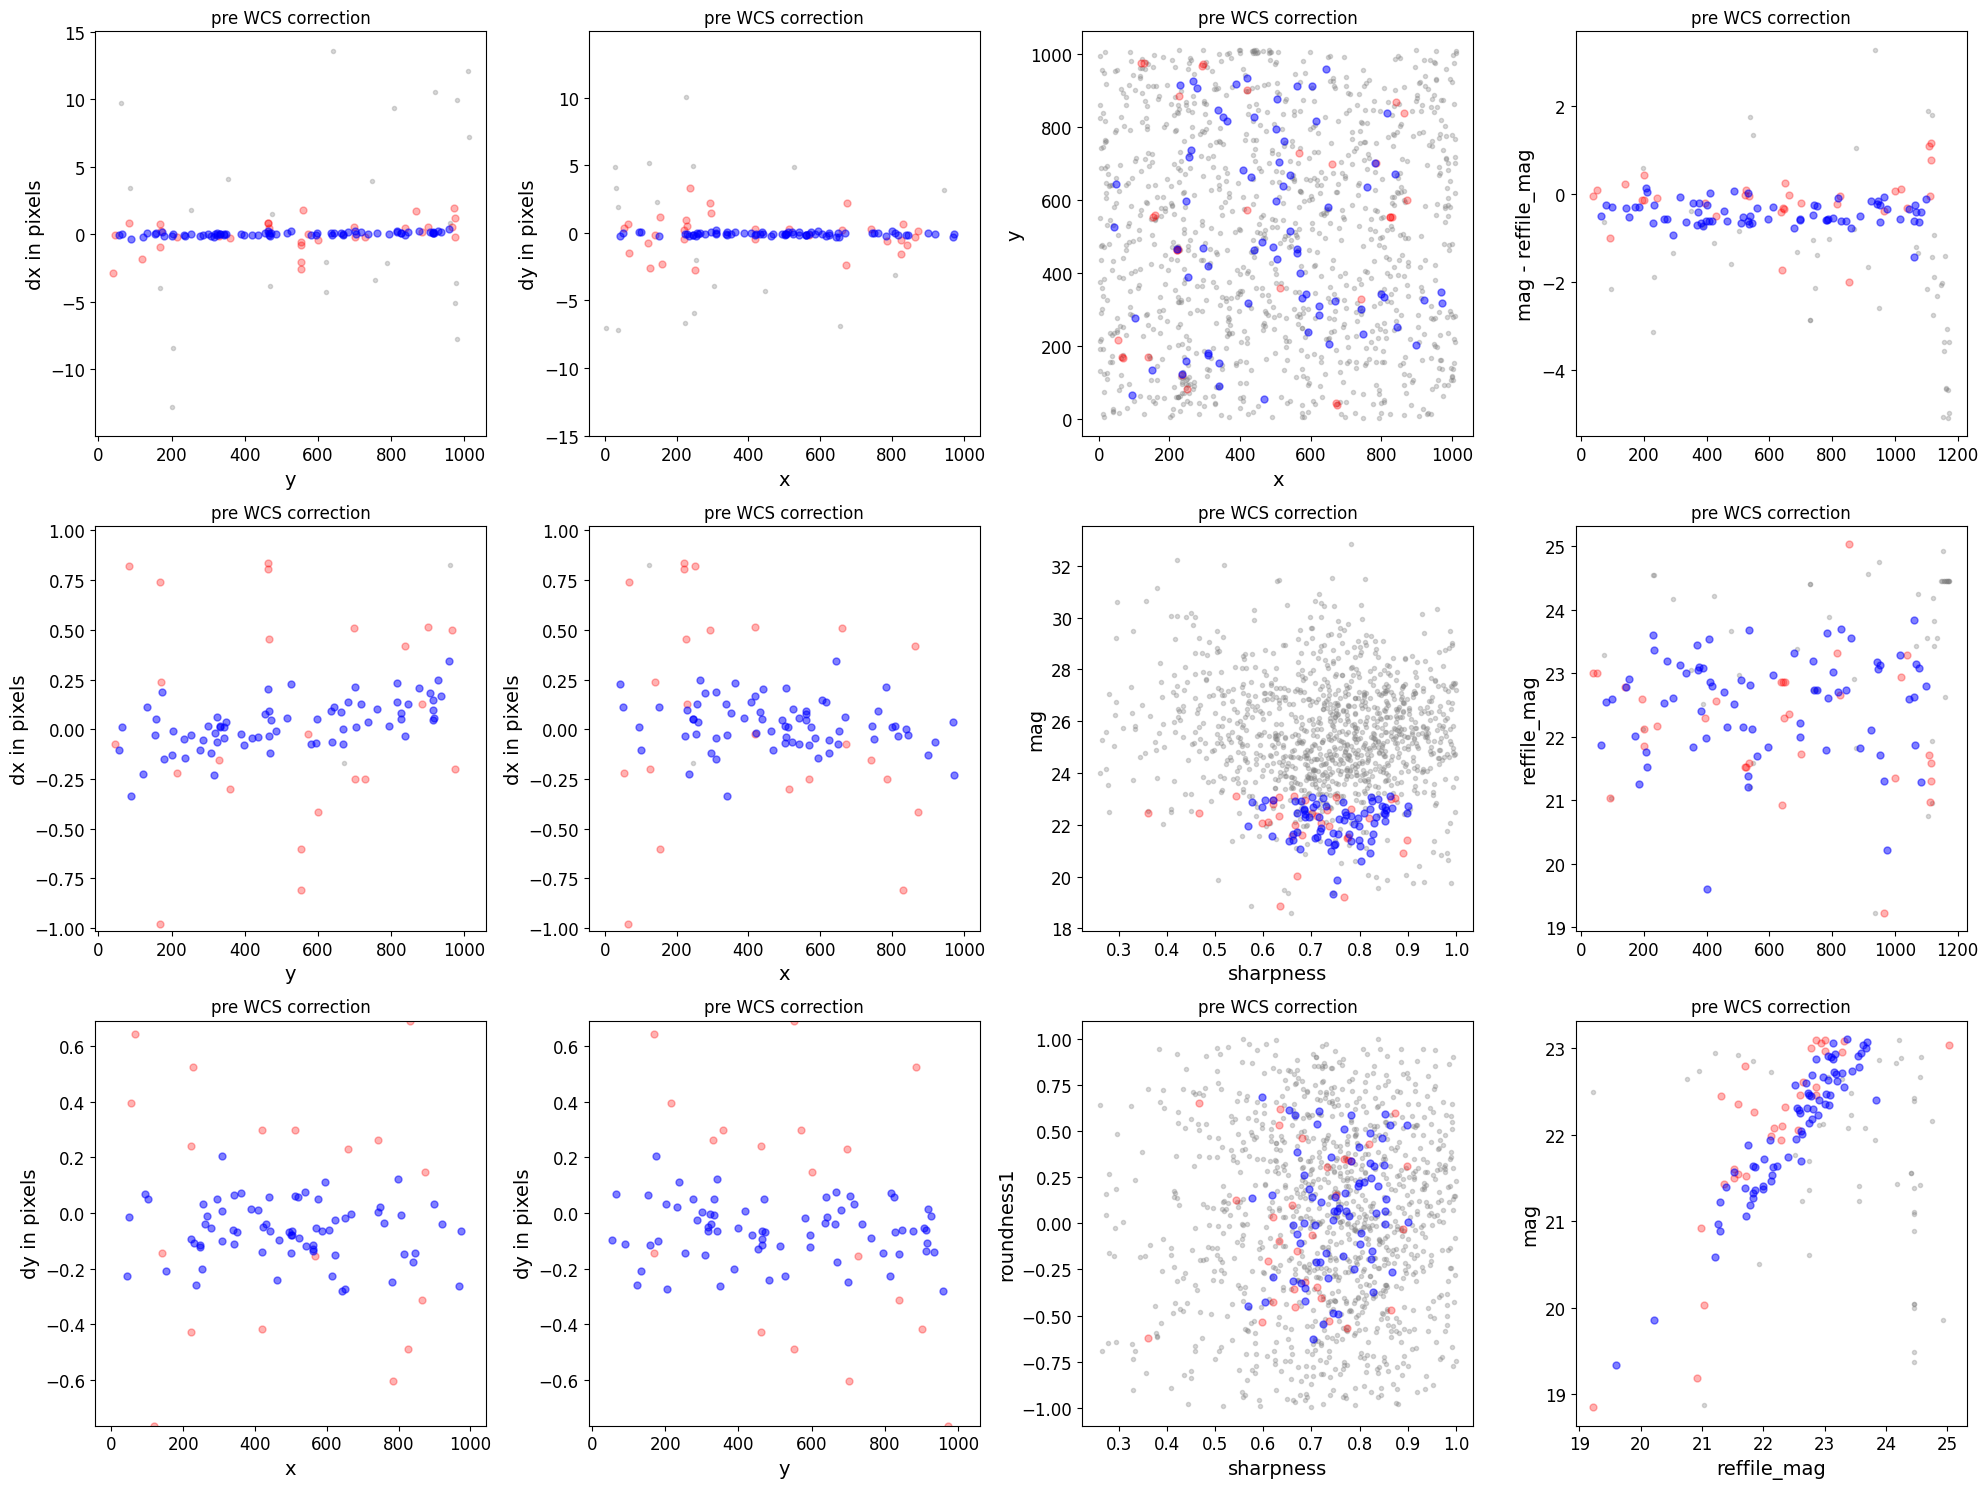

./jhat_run1//icn105dwq_jhat.fits


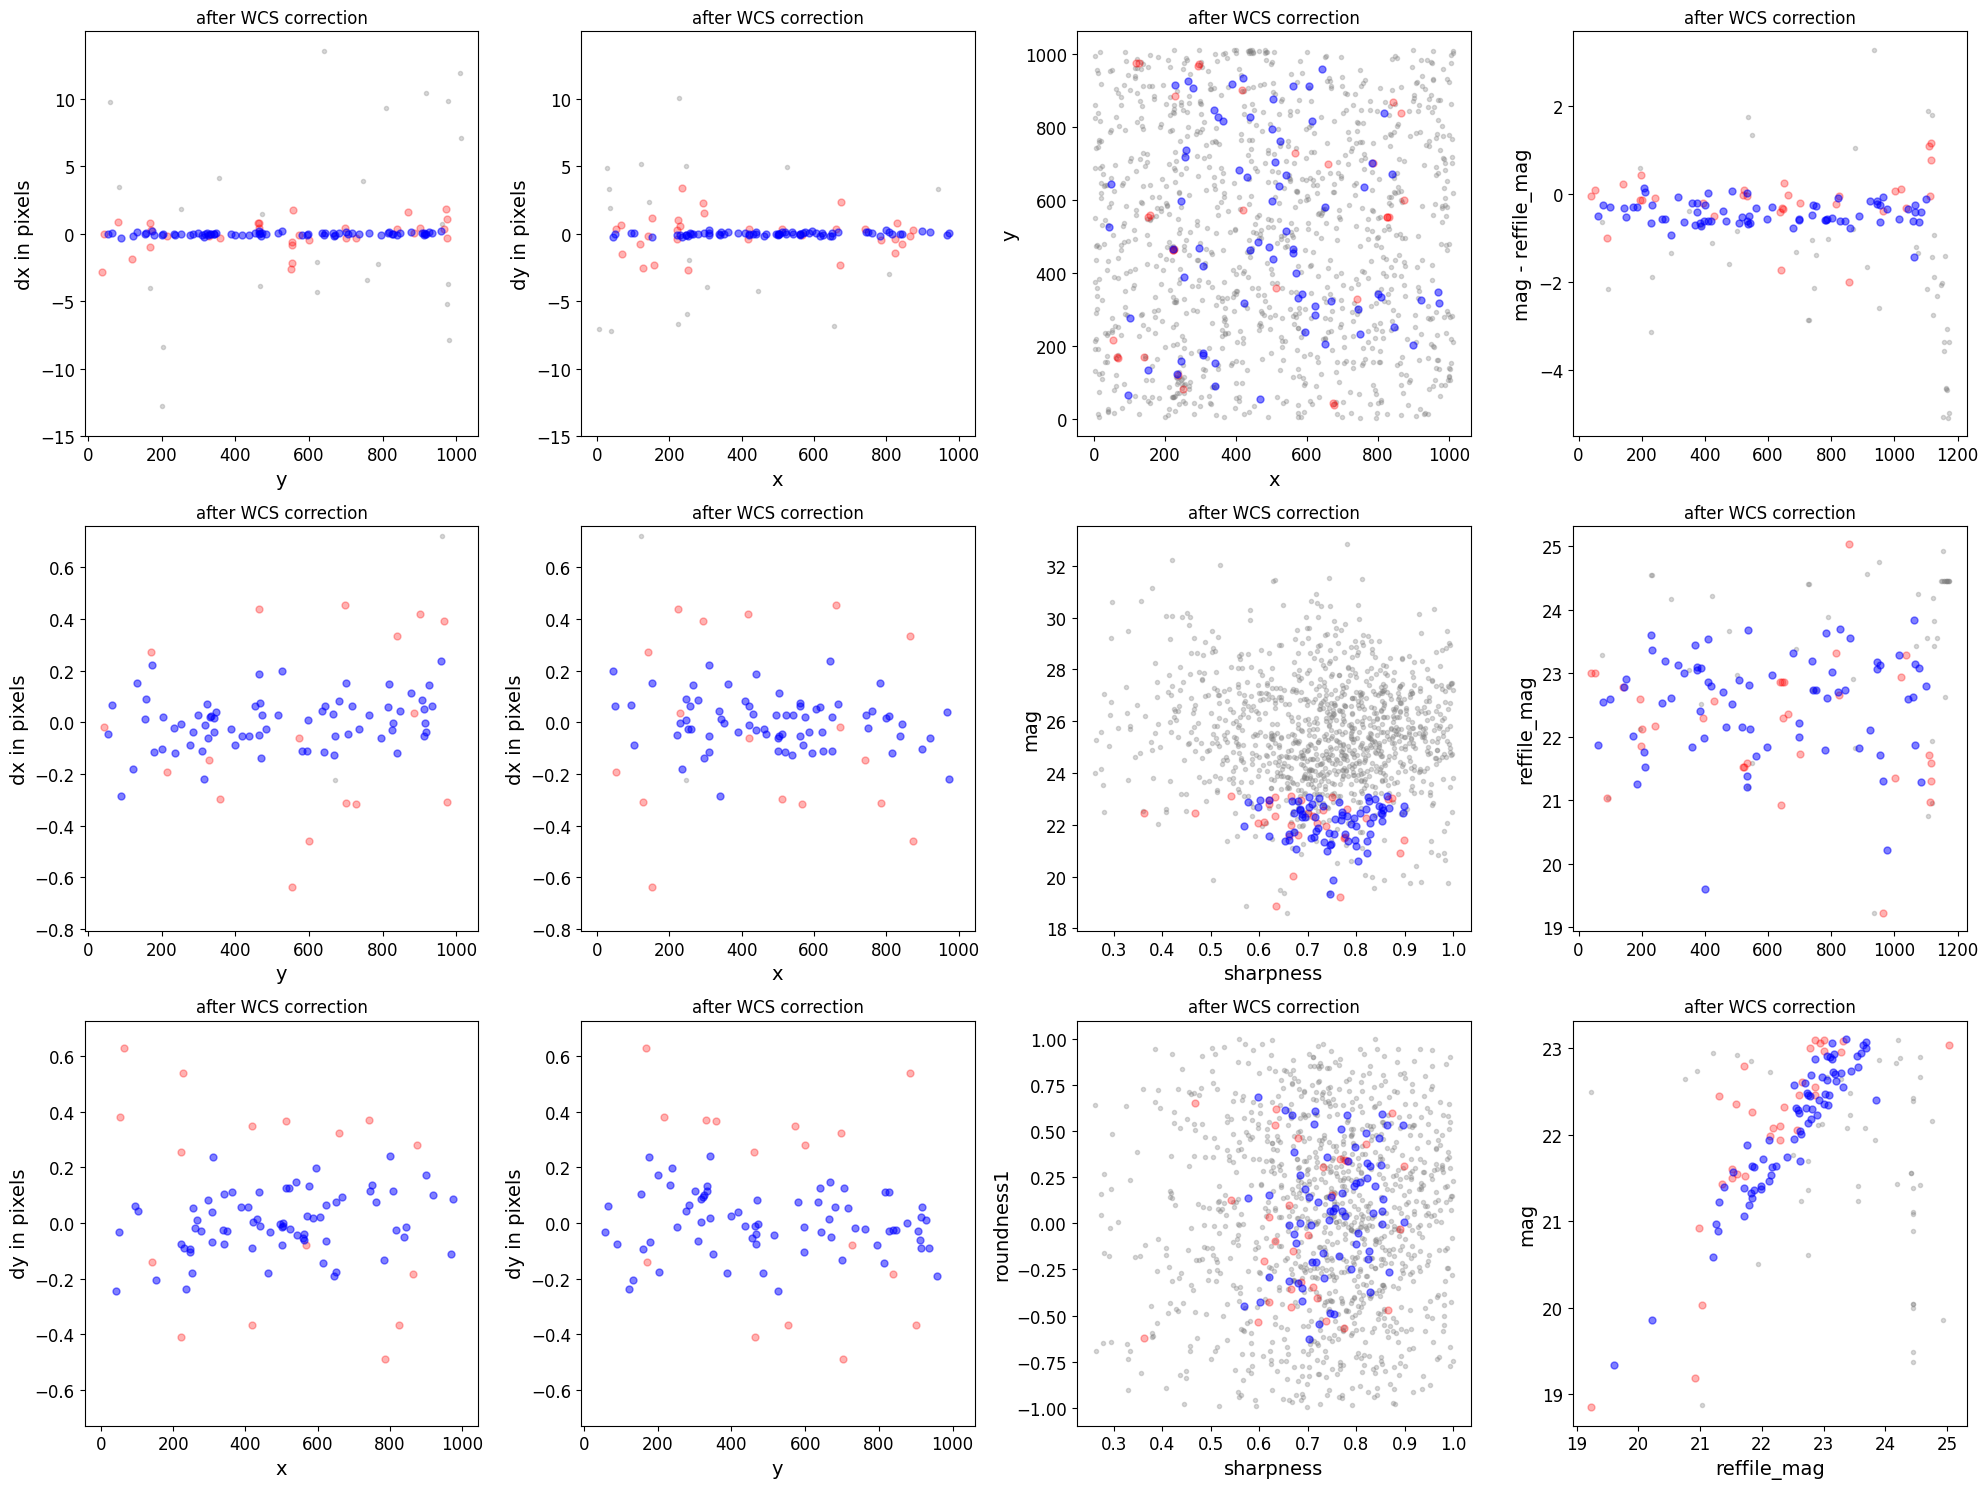

*** Note: close plots to continue!


0

In [103]:
wcs_align = st_wcs_align()


wcs_align.run_all('jhat_run1/icn105dwq_flt.fits',
              telescope='hst',
              outsubdir='jhat_run1/',
          refcat_racol='ra',
          refcat_deccol='dec',
          refcat_magcol='mag',
          refcat_magerrcol='dmag',
          overwrite=True,
          d2d_max=.5,
          showplots=2,
          refcatname=ref_catname,
          find_stars_threshold = 3,
          xshift=-0.059197,
          yshift=0.069278,
          iterate_with_xyshifts=True,
                  
          histocut_order='dxdy',
              sharpness_lim=(0.3,0.9),
              roundness1_lim=(-0.7, 0.7),
              SNR_min= 3,
              dmag_max=1.0,
              Nbright = 150,
              objmag_lim =(14,25))

In [35]:
obstable

image,exptime,datetime,filter,instrument,detector,zeropoint,chip,imagenumber,visit,drizname
str20,float64,str19,str5,str12,str7,float64,str2,int64,int64,str99
./icn105dvq_flt.fits,452.936035,2014-10-06T14:22:18,f140w,wfc3_ir_full,wfc3_ir,26.45070798348457,IR,0,1,./wfc3.f140w.ut141006_0001.drz.fits
./icn105dwq_flt.fits,452.936035,2014-10-06T14:31:00,f140w,wfc3_ir_full,wfc3_ir,26.45070798348457,IR,0,1,./wfc3.f140w.ut141006_0001.drz.fits
./icn105dyq_flt.fits,252.934357,2014-10-06T14:39:42,f105w,wfc3_ir_full,wfc3_ir,26.26452349235223,IR,0,2,./wfc3.f105w.ut141006_0002.drz.fits
./icn105e0q_flt.fits,252.934357,2014-10-06T14:44:57,f105w,wfc3_ir_full,wfc3_ir,26.26452349235223,IR,0,2,./wfc3.f105w.ut141006_0002.drz.fits
./icn105e2q_flt.fits,252.934357,2014-10-06T15:35:50,f105w,wfc3_ir_full,wfc3_ir,26.26452349235223,IR,0,2,./wfc3.f105w.ut141006_0002.drz.fits
./icn105e3q_flt.fits,252.934357,2014-10-06T15:41:05,f105w,wfc3_ir_full,wfc3_ir,26.26452349235223,IR,0,2,./wfc3.f105w.ut141006_0002.drz.fits


### Main

In [ ]:
  def run_tweakreg(self, obstable, reference, do_cosmic=True, skip_wcs=False,
#     search_radius=None, update_hdr=True):

#     if self.options['args'].work_dir:
#         outdir = self.options['args'].work_dir
#     else:
#         outdir = '.'

#     os.chdir(outdir)

#     # Get options from object
#     options = self.options['global_defaults']
#     # Check if tweakreg has already been run on each image
#     run_images = self.check_images_for_tweakreg(list(obstable['image']))
#     if not run_images: return('tweakreg success', None)
#     if reference in run_images: run_images.remove(reference)

#     # Records what the offsets are for the files run through tweakreg
#     shift_table = Table([run_images,[np.nan]*len(run_images),
#         [np.nan]*len(run_images)], names=('file','xoffset','yoffset'))

#     # Check if we just removed all of the images
#     if not run_images: #not needed
#         warning = 'WARNING: All images have been run through tweakreg.'
#         print(warning)
#         return(True)

#     print('Need to run tweakreg for images:')
#     self.input_list(obstable['image'], show=True, save=False)

#     tmp_images = []
#     for image in run_images:
#         if self.updatewcs and not skip_wcs:
#             det = '_'.join(self.get_instrument(image).split('_')[:2])
#             wcsoptions = self.options['detector_defaults'][det]
#             self.update_image_wcs(image, wcsoptions)

#         if not do_cosmic:
#             tmp_images.append(image)
#             continue

#         # wfc3_ir doesn't need cosmic clean and assume reference is cleaned
#         if (image == reference or 'wfc3_ir' in self.get_instrument(image)):
#             message = 'Skipping adjustments for {file} as WFC3/IR or reference'
#             print(message.format(file=image))
#             tmp_images.append(image)
#             continue

#         rawtmp = image.replace('.fits','.rawtmp.fits')
#         tmp_images.append(rawtmp)

#         # Check if rawtmp already exists
#         if os.path.exists(rawtmp):
#             message = '{file} exists. Skipping...'
#             print(message.format(file=rawtmp))
#             continue

#         # Copy the raw data into a temporary file
#         shutil.copyfile(image, rawtmp)

#         # Clean cosmic rays so they aren't used for alignment
#         inst = self.get_instrument(image).split('_')[0]
#         crpars = self.options['instrument_defaults'][inst]['crpars']
#         self.run_cosmic(rawtmp, crpars) #nircam l2 is cosmic ray corrected

#     modified = False
#     ref_images = self.pick_deepest_images(tmp_images)
#     deepest = sorted(ref_images, key=lambda im: fits.getval(im, 'EXPTIME'))[-1]
#     if (not reference or reference=='dummy.fits'):
#         reference = 'dummy.fits'
#         message = 'Copying {deep} to reference dummy.fits'
#         print(message.format(deep=deepest))
#         shutil.copyfile(deepest, reference)
#     elif not self.prepare_reference_tweakreg(reference):
#         # Can't use this reference image, just use one of the input
#         reference = 'dummy.fits'
#         message = 'Copying {deep} to reference dummy.fits'
#         print(message.format(deep=deepest))
#         shutil.copyfile(deepest, reference)
#     else:
#         modified = True

#     message = 'Tweakreg is executing...'
#     print(message)

#     start_tweak = time.time()

#     tweakreg_success = False
#     tweak_img = copy.copy(tmp_images)
#     ithresh = 10 ; rthresh = 10
#     shallow_img = []
#     thresh_data = None
#     tries = 0

#     while (not tweakreg_success and tries < 10):
#         tweak_img = self.check_images_for_tweakreg(tweak_img)
#         if not tweak_img: break
#         if tweak_img:
#             # Remove images from tweak_img if they are too shallow
#             if shallow_img:
#                 for img in shallow_img:
#                     if img in tweak_img:
#                         tweak_img.remove(img)

#             if len(tweak_img)==0:
#                 error = 'ERROR: removed all images as shallow'
#                 print(error)
#                 tweak_img = copy.copy(tmp_images)
#                 tweak_img = self.check_images_for_tweakreg(tweak_img)

#             # If we've tried multiple runs and there are images in input
#             # list with TWEAKSUC and reference image=dummy.fits, we might need
#             # to try a different reference image
#             success = list(set(tmp_images) ^ set(tweak_img))
#             if tries > 1 and reference=='dummy.fits' and len(success)>0:
#                 # Make random success image new dummy image
#                 n = len(success)-1
#                 shutil.copyfile(success[random.randint(0,n)],'dummy.fits')

#             # This estimates what the input threshold should be and cuts
#             # out images based on number of detected sources from previous
#             # rounds of tweakreg
#             message = '\n\nReference image: {ref} \n'
#             message += 'Images: {im}'
#             print(message.format(ref=reference, im=','.join(tweak_img)))

#             # Get deepest image and use threshold from that
#             deepest = sorted(tweak_img,
#                 key=lambda im: fits.getval(im, 'EXPTIME'))[-1]

#             if not thresh_data or deepest not in thresh_data['file']:
#                 inp_data = self.get_tweakreg_thresholds(deepest,
#                     options['nbright']*4)
#                 thresh_data = self.add_thresh_data(thresh_data, deepest,
#                     inp_data)
#             mask = thresh_data['file']==deepest
#             inp_thresh = thresh_data[mask][0]
#             print('Getting image threshold...')
#             new_ithresh = self.get_best_tweakreg_threshold(inp_thresh,
#                 options['nbright']*4)

#             if not thresh_data or reference not in thresh_data['file']:
#                 inp_data = self.get_tweakreg_thresholds(reference,
#                     options['nbright']*4)
#                 thresh_data = self.add_thresh_data(thresh_data, reference,
#                     inp_data)
#             mask = thresh_data['file']==reference
#             inp_thresh = thresh_data[mask][0]
#             print('Getting reference threshold...')
#             new_rthresh = self.get_best_tweakreg_threshold(inp_thresh,
#                 options['nbright']*4)

#             if not rthresh: rthresh = self.threshold
#             if not ithresh: ithresh = self.threshold

#             # Other input options
#             nbright = options['nbright']
#             minobj = options['minobj']
#             search_rad = int(np.round(options['search_rad']))
#             if search_radius: search_rad = search_radius

#             rconv = 3.5 ; iconv = 3.5 ; tol = 0.25
#             if 'wfc3_ir' in self.get_instrument(reference):
#                 rconv = 2.5
#             if all(['wfc3_ir' in self.get_instrument(i)
#                 for i in tweak_img]):
#                 iconv = 2.5 ; tol = 0.6
#             if 'wfpc2' in self.get_instrument(reference):
#                 rconv = 2.5
#             if all(['wfpc2' in self.get_instrument(i)
#                 for i in tweak_img]):
#                 iconv = 2.5 ; tol = 0.5


#             # Don't want to keep trying same thing over and over
#             if (new_ithresh>=ithresh or new_rthresh>=rthresh) and tries>1:
#                 # Decrease the threshold and increase tolerance
#                 message = 'Decreasing threshold and increasing tolerance...'
#                 print(message)
#                 ithresh = np.max([new_ithresh*(0.95**tries), 3.0])
#                 rthresh = np.max([new_rthresh*(0.95**tries), 3.0])
#                 tol = tol * 1.3**tries
#                 search_rad = search_rad * 1.2**tries
#             else:
#                 ithresh = new_ithresh
#                 rthresh = new_rthresh

#             if tries > 7:
#                 minobj = 7

#             message = '\nAdjusting thresholds:\n'
#             message += 'Reference threshold={rthresh}\n'
#             message += 'Image threshold={ithresh}\n'
#             message += 'Tolerance={tol}\n'
#             message += 'Search radius={rad}\n'
#             print(message.format(ithresh='%2.4f'%ithresh,
#                 rthresh='%2.4f'%rthresh, tol='%2.4f'%tol,
#                 rad='%2.4f'%search_rad))

#             outshifts = os.path.join(outdir, 'drizzle_shifts.txt')

#             try:
#                 tweakreg.TweakReg(files=tweak_img, refimage=reference,
#                     verbose=False, interactive=False, clean=True,
#                     writecat=True, updatehdr=update_hdr, reusename=True,
#                     rfluxunits='counts', minobj=minobj, wcsname='TWEAK',
#                     searchrad=search_rad, searchunits='arcseconds', runfile='',
#                     tolerance=tol, refnbright=nbright, nbright=nbright,
#                     separation=0.5, residplot='No plot', see2dplot=False,
#                     fitgeometry='shift',
#                     imagefindcfg = {'threshold': ithresh,
#                         'conv_width': iconv, 'use_sharp_round': True},
#                     refimagefindcfg = {'threshold': rthresh,
#                         'conv_width': rconv, 'use_sharp_round': True},
#                     shiftfile=True, outshifts=outshifts)

#                 # Reset shallow_img list
#                 shallow_img = []

#             except AssertionError as e:
#                 self.tweakreg_error(e)

#                 message = 'Re-running tweakreg with shallow images removed:'
#                 print(message)
#                 for img in tweak_img:
#                     nsources = self.get_nsources(img, ithresh)
#                     if nsources < 1000:
#                         shallow_img.append(img)

#             # Occurs when all images fail alignment
#             except TypeError as e:
#                 self.tweakreg_error(e)

#             # Record what the shifts are for each of the files run
#             message='Reading in shift file: {file}'
#             print(message.format(file=outshifts))
#             shifts = Table.read(outshifts, format='ascii', names=('file',
#                 'xoffset','yoffset','rotation1','rotation2','scale1','scale2'))

#             self.apply_tweakreg_success(shifts)

#             # Add data from output shiftfile to shift_table
#             for row in shifts:
#                 filename = os.path.basename(row['file'])
#                 filename = filename.replace('.rawtmp.fits','')
#                 filename = filename.replace('.fits','')

#                 idx = [i for i,row in enumerate(shift_table)
#                     if filename in row['file']]

#                 if len(idx)==1:
#                     shift_table[idx[0]]['xoffset']=row['xoffset']
#                     shift_table[idx[0]]['yoffset']=row['yoffset']

#             if not self.check_images_for_tweakreg(tmp_images):
#                 tweakreg_success = True

#             tries += 1

#     message = 'Tweakreg took {time} seconds to execute.\n\n'
#     print(message.format(time = time.time()-start_tweak))

#     print(shift_table)

    # tweakreg improperly indexes the CRVAL1 and CRVAL2 values
    # TODO: If drizzlepac fixes this then get rid of this code
    for image in tmp_images:
        rawtmp = image
        rawhdu = fits.open(rawtmp, mode='readonly')

        tweaksuc = False
        if ('TWEAKSUC' in rawhdu[0].header.keys() and
            rawhdu[0].header['TWEAKSUC']==1):
            tweaksuc = True

        if 'wfc3_ir' in self.get_instrument(image): continue

        for i,h in enumerate(rawhdu):
            if (tweaksuc and 'CRVAL1' in h.header.keys() and
                'CRVAL2' in h.header.keys()):
                rawhdu[i].header['CRPIX1']=rawhdu[i].header['CRPIX1']-0.5
                rawhdu[i].header['CRPIX2']=rawhdu[i].header['CRPIX2']-0.5

        rawhdu.writeto(rawtmp, overwrite=True)

    if not skip_wcs:
        for image in run_images:
            # Copy image over now to perform other image header updates
            if (image == reference or 'wfc3_ir' in self.get_instrument(image)):
                continue

            message = '\n\nUpdating image data for image: {im}'
            print(message.format(im=image))
            rawtmp = image.replace('.fits','.rawtmp.fits')

            rawhdu = fits.open(rawtmp, mode='readonly')
            hdu    = fits.open(image, mode='readonly')
            newhdu = fits.HDUList()

            print('Current image info:')
            hdu.info()

            for i, h in enumerate(hdu):
                if h.name=='SCI':
                    if 'flc' in image or 'flt' in image:
                        if len(rawhdu)>=i+2 and rawhdu[i+2].name=='DQ':
                            self.copy_wcs_keys(rawhdu[i], rawhdu[i+2])
                    elif 'c0m' in image:
                        maskfile = image.split('_')[0]+'_c1m.fits'
                        if os.path.exists(maskfile):
                            maskhdu = fits.open(maskfile)
                            self.copy_wcs_keys(rawhdu[i], maskhdu[i])
                            maskhdu.writeto(maskfile, overwrite=True)

                # Skip WCSCORR for WFPC2 as non-standard hdu
                if 'wfpc2' in self.get_instrument(image).lower():
                    if h.name=='WCSCORR':
                        continue

                # Get the index of the corresponding extension in rawhdu.  This
                # can be different from "i" if extensions were added or
                # rearranged
                ver = int(h.ver) ; name = str(h.name).strip()
                idx = -1

                for j,rawh in enumerate(rawhdu):
                    if str(rawh.name).strip()==name and int(rawh.ver)==ver:
                        idx = j

                # If there is no corresponding extension, then continue
                if idx < 0:
                    message = 'Skip extension {i},{ext},{ver} '
                    message += '- no match in {f}'
                    print(message.format(i=i, ext=name, ver=ver, f=rawtmp))
                    continue

                # If we can access the data in both extensions, copy from
                if h.name!='DQ':
                    if 'data' in dir(h) and 'data' in dir(rawhdu[idx]):
                        if (rawhdu[idx].data is not None and
                            h.data is not None):
                            if rawhdu[idx].data.dtype==h.data.dtype:
                                rawhdu[idx].data = h.data

                # Copy the rawtmp extension into the new file
                message = 'Copy extension {i},{ext},{ver}'
                print(message.format(i=idx, ext=name, ver=ver))
                newhdu.append(copy.copy(rawhdu[idx]))

            if 'wfpc2' in self.get_instrument(image).lower():
                # Adjust number of extensions to 4
                newhdu[0].header['NEXTEND']=4

            print('\n\nNew image info:')
            newhdu.info()

            newhdu.writeto(image, output_verify='silentfix', overwrite=True)

            if (os.path.isfile(rawtmp) and not self.options['args'].cleanup):
                os.remove(rawtmp)

    # Clean up temporary files and output
    if os.path.isfile('dummy.fits'):
        os.remove('dummy.fits')

    if not self.options['args'].keep_objfile:
        for file in glob.glob('*.coo'):
            os.remove(file)

    if modified:
        # Re-sanitize reference using main sanitize function
        self.sanitize_reference(reference)

    return(tweakreg_success, shift_table)